# How to create a gif showing how the brain substructures change over time?

In [1]:
from pathlib import Path

import pyvista as pv
from IPython.display import Image

from polpo.preprocessing import PartiallyInitializedStep
from polpo.preprocessing.dict import DictMap, NestedDictSwapper
from polpo.preprocessing.load.pregnancy import (
    MATERNAL_STRUCTS,
    DenseMaternalMeshLoader,
)
from polpo.preprocessing.mesh.io import PvReader
from polpo.preprocessing.mesh.registration import PvAlign

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [2]:
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

## Loading meshes

NB: we perform rigid alignment on the meshes wrt the first mesh.

In [3]:
prep_pipe = PartiallyInitializedStep(
    Step=lambda **kwargs: DictMap(PvAlign(**kwargs)),
    _target=lambda meshes: meshes[list(meshes.keys())[0]],
    max_iterations=500,
)

In [4]:
subject_id = "01"

# side, struct, time
meshes = {True: {}, False: {}}  # bool represents side
for left in meshes.keys():
    for struct in MATERNAL_STRUCTS:
        file_finder = DenseMaternalMeshLoader(
            subject_id=subject_id,
            as_dict=True,
            left=left,
            struct=struct,
        )

        pipe = file_finder + DictMap(PvReader()) + prep_pipe

        meshes[left][struct] = pipe()

For easier handling of nested, we swap the nested structure of the `dict`.

In [5]:
# time, side, struct
meshes_ = (DictMap(NestedDictSwapper()) + NestedDictSwapper())(meshes)

## Create gif

In [6]:
outputs_dir = Path("_images")
if not outputs_dir.exists():
    outputs_dir.mkdir()

gif_name = outputs_dir / f"{subject_id}_all_structs.gif"


pl = pv.Plotter(
    shape=(2, len(MATERNAL_STRUCTS)),
    border=False,
    off_screen=True,
    notebook=False,
    window_size=(1920, 1080),
)

pl.open_gif(gif_name.as_posix(), fps=3)

rendered_meshes = {}
for time_index, (session_key, meshes_sides) in enumerate(meshes_.items()):
    for left, meshes_side in meshes_sides.items():
        side_name = "L" if left else "R"
        for pos, (struct, mesh) in enumerate(meshes_side.items()):
            pl.subplot(int(left), pos)

            if time_index:
                rendered_meshes[left, pos].points = mesh.points
                pl.render()
            else:
                rendered_meshes[left, pos] = mesh_ = mesh.copy()
                pl.add_mesh(mesh_, show_edges=True)

            pl.add_title(
                f"{subject_id}, {struct}, {side_name}, {session_key}", font_size=8
            )

    pl.write_frame()

pl.close()

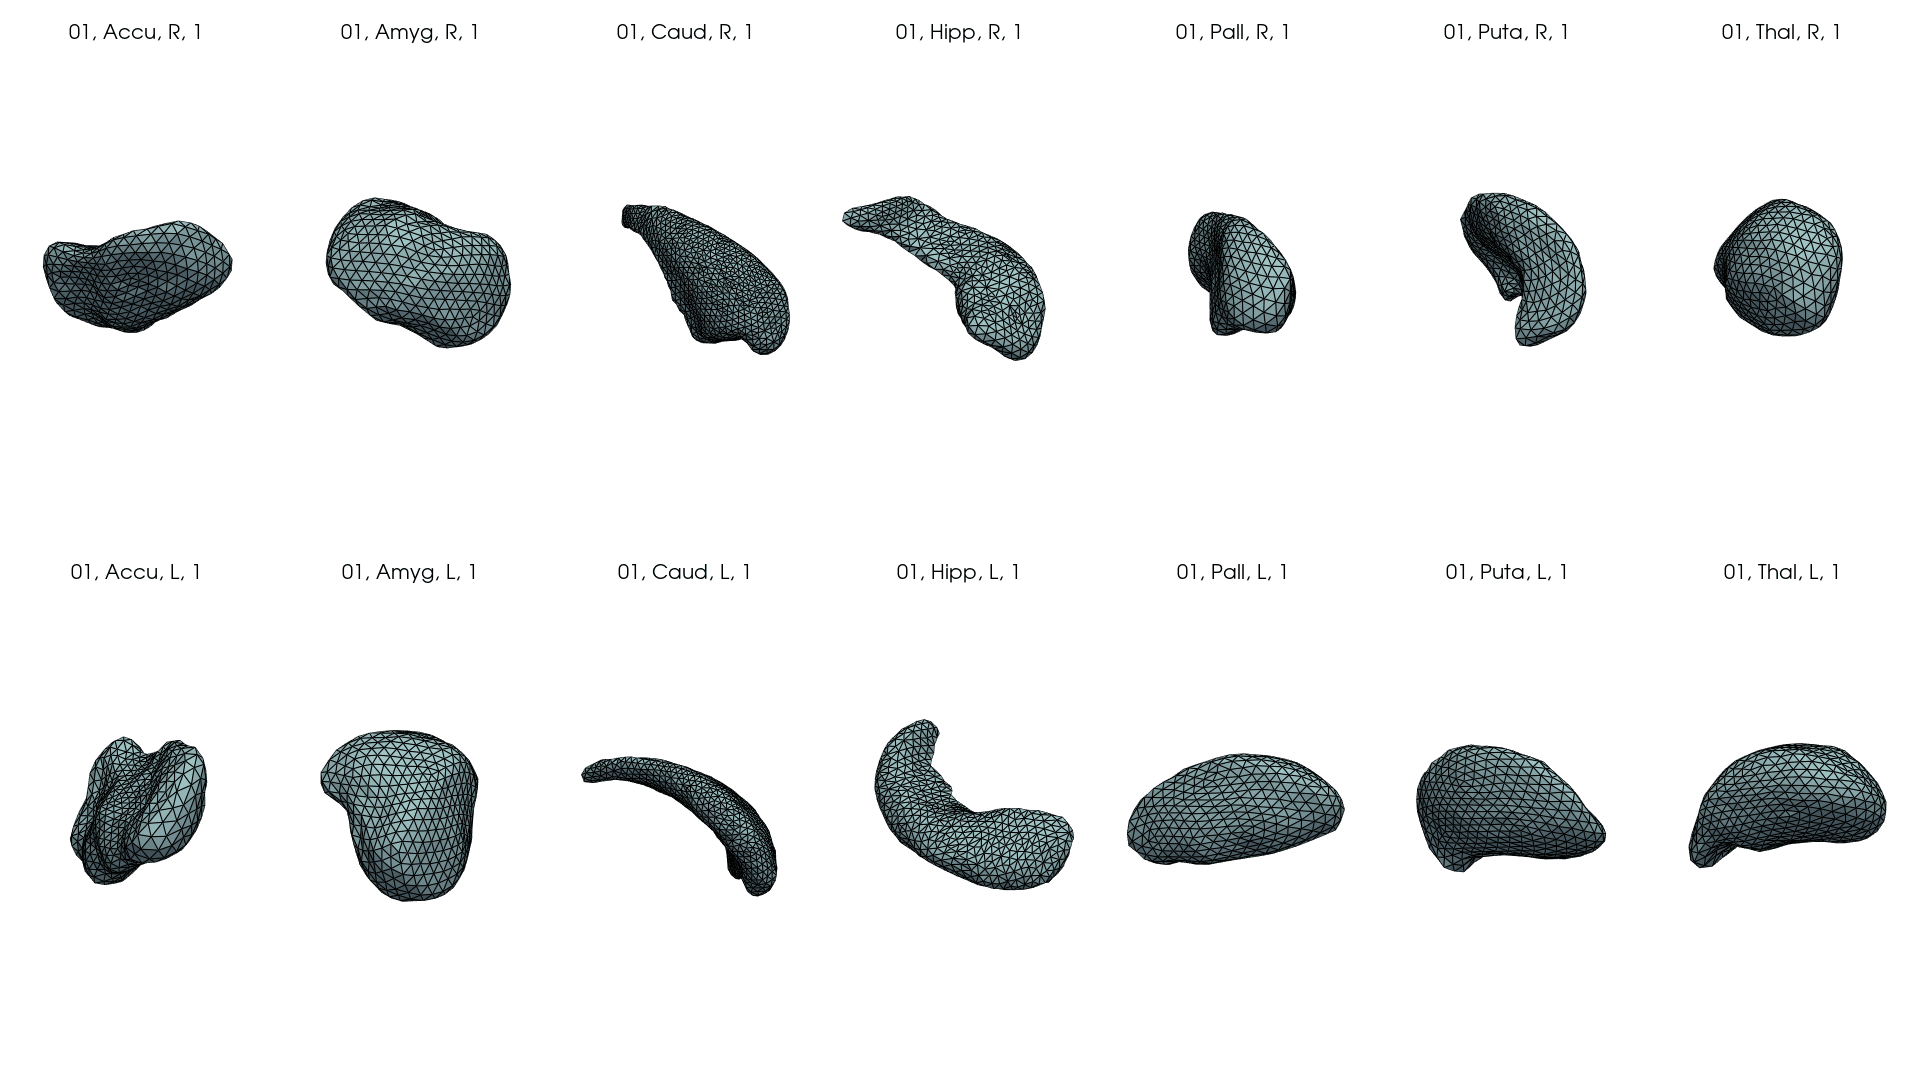

In [7]:
Image(open(gif_name, "rb").read())